## CHARACTERIZATION AND CLASSIFICATION OF BIOMECHANICAL SIGNALS

## 1. Introduction.

Firstly, let's do a brief recall of what we have and what we need to achieve.

From the one hand, the signals we are working with are **biomechanical signals** so they have been produced by motion and displacement. They are accelerometry signals from a **gait analysis experiment**.

This type of analysis has been widely used in diagnostic decision making, comparative biomechanics and biometric identification, among others. Plenty of approaches for this locomotion analysis have been developed in both academic and industrial fields to detect especially neurological disorders [1]

In this case, we have a database with different signals from 60 volunteer which belongs to three different types -free walk, placebo and with weight-, which are more detailed explained in the presentation of the Challenge. 

Our goal is to obtain a series of parameters using signal processing and analysis techniques to characterize each of the groups. Thence, we can create a decisor which will be able to predict the category of the rest of the signals.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import statistics as st
from sklearn import preprocessing
from sklearn.decomposition import PCA
import os

In [2]:
### We have created a script collecting different functions regarding our preprocessing
import pre_processing as pr

So let's start having a **general overview** of the raw signals. 

We are going to plot the three axis from the right foot and the left hip of one the participants from each group.

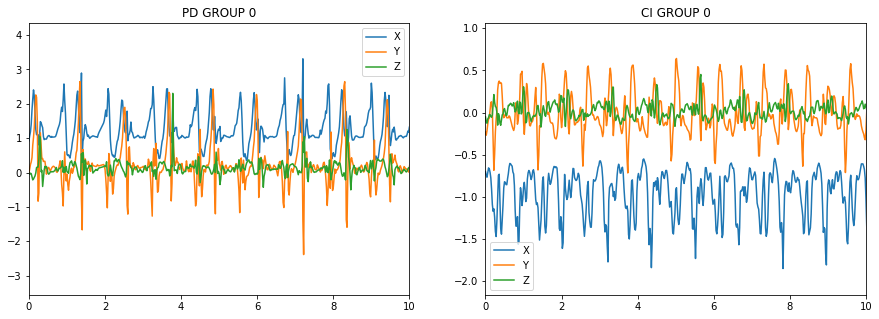

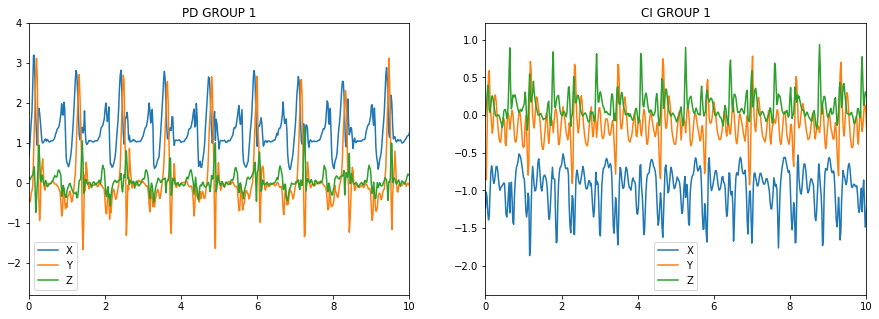

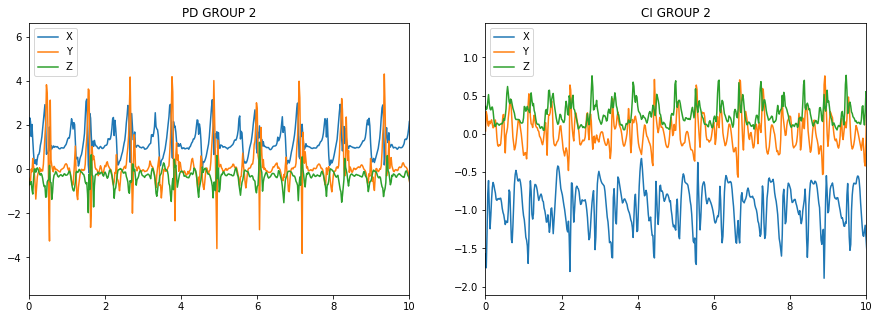

In [3]:
fs = 50
type_patient = ["0","1","2"]

#We iterate along all the types to take the correspondient data

for t in type_patient:
    x_PD = pr.read_data(t,"x","PD")[0]
    y_PD = pr.read_data(t,"y","PD")[0]
    z_PD = pr.read_data(t,"z","PD")[0]

    x_CI = pr.read_data(t,"x","CI")[0]
    y_CI = pr.read_data(t,"y","CI")[0]
    z_CI = pr.read_data(t,"z","CI")[0]

    x_axis = np.arange(0,len(x_PD)/fs,1/fs) 


    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(x_axis,x_PD, label = "X")
    plt.plot(x_axis,y_PD, label = "Y")
    plt.plot(x_axis,z_PD, label = "Z")
    plt.legend()
    plt.xlim(0,10)
    plt.title("PD GROUP " + t)

    plt.subplot(1,2,2)
    plt.plot(x_axis,x_CI, label = "X")
    plt.plot(x_axis,y_CI, label = "Y")
    plt.plot(x_axis,z_CI, label = "Z")
    plt.legend()
    plt.xlim(0,10)
    plt.title("CI GROUP " + t)

As expected, we cannot find any pattern that will help us to define each group just seeing the plots of the raw signals. However, what we can appreciate is the presence of noice.

So next step is **preprocessing**. We need to get rid of this noise so the characteristics that will help us to define each group are not influenced by it.

## 1. Preprocessing

The goal of this section is to prepare the signals in order to work with them in a more precise way.  

### 1.1.Filtering. 
Noise in biomechanical signals is usually **low in amplitude and non-deterministic** which means it is very difficult to predict [2] .Besides, we are going to plot some periodograms (which will be more detailed explained in following sections) to helps us decide which frequencies do not give us important information so we could eliminate them.

Only mean periodograms from group zero are going to be shown as they will give us the enough information of the important bandwidth for all the signals.

In [4]:
def raw_PSD(type_patient,axis,part_body):
    
    raw = pr.read_data(type_patient,axis,part_body)
    fs = 50
    Pxx_list = []
    
    for s in raw:
        f_welch, Pxx_welch = signal.welch(s,fs=fs, window='hamming',nperseg= 512, nfft = 1024)
        Pxx_list.append(Pxx_welch) 

    return f_welch, Pxx_list

Text(0, 0.5, 'Magnitude (dB)')

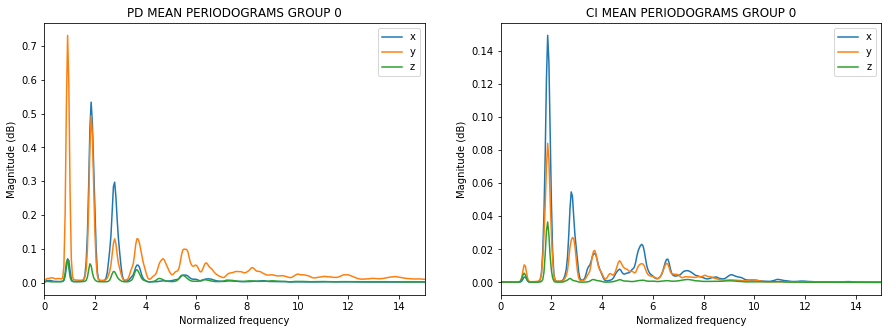

In [5]:
plt.figure(figsize=[15,5])

plt.subplot(121)
plt.plot(raw_PSD("0","x","PD")[0], np.mean(raw_PSD("0","x","PD")[1], axis=0),label = "x")
plt.plot(raw_PSD("0","y","PD")[0], np.mean(raw_PSD("0","y","PD")[1], axis=0),label = "y")
plt.plot(raw_PSD("0","z","PD")[0], np.mean(raw_PSD("0","z","PD")[1], axis=0),label = "z")
plt.xlim(0, 15)
plt.legend(loc="upper right") 
plt.title("PD MEAN PERIODOGRAMS GROUP 0")
plt.xlabel('Normalized frequency')
plt.ylabel('Magnitude (dB)')

plt.subplot(122)
plt.plot(raw_PSD("0","x","CI")[0], np.mean(raw_PSD("0","x","CI")[1], axis=0),label = "x")
plt.plot(raw_PSD("0","y","CI")[0], np.mean(raw_PSD("0","y","CI")[1], axis=0),label = "y")
plt.plot(raw_PSD("0","z","CI")[0], np.mean(raw_PSD("0","z","CI")[1], axis=0),label = "z")
plt.xlim(0, 15)
plt.legend(loc="upper right") 
plt.title("CI MEAN PERIODOGRAMS GROUP 0")
plt.xlabel('Normalized frequency')
plt.ylabel('Magnitude (dB)')

Acceleration signals could be assumed as almost-pure sinusoidal signals i.e. **most of the energy is going to be concentrated around the main peak**. In most cases, acceleration signals are modeled as pseudo-periodic signals with a **structure of harmonics**, which indicate the pattern repeated along the gait. []

This is exactly what we finally obtain. The main peak is located in different frequencies depending if they are signals of PD or CI (right foot of left hip) but in both cases the regular cycle of the gait is represented by the harmonics. 

However, it is also clear that these mentioned representations of gait are also pertubed in some points like between frequencies 4/4.5 and 6 Hz in both mean periodograms which indicates they are influenced by noise. After these frequencies, no important information appears. Thence, we decide to apply a **bandpass between 0.3 and 5 Hz**.


Now, we should decide which type of filter we are going to apply depending on its response. For so, we are going to plot several signals, applying both filters and observing how they change with respect to noise.

Text(0.5, 1.0, 'APPLICATION OF IIR FILTER')

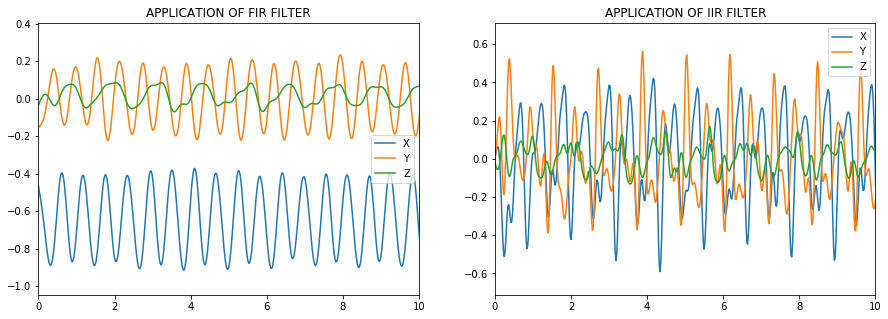

In [6]:
fs = 50

x = pr.read_data("0","x","CI")[0]
y = pr.read_data("0","y","CI")[0]
z = pr.read_data("0","z","CI")[0]

b_IIR,a_IIR = signal.butter(4,[0.3,5] ,btype = "bandpass", fs=fs)
b_FIR = signal.firwin(64,[0.3,5], nyq = fs, pass_zero = False)

x_FIR = signal.filtfilt(b_FIR,1.0,x)
y_FIR = signal.filtfilt(b_FIR,1.0,y)
z_FIR = signal.filtfilt(b_FIR,1.0,z)

x_IIR = signal.filtfilt(b_IIR,a_IIR,x)
y_IIR = signal.filtfilt(b_IIR,a_IIR,y)
z_IIR = signal.filtfilt(b_IIR,a_IIR,z)

x_axis = np.arange(0,len(x)/fs,1/fs)

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(x_axis,x_FIR, label = "X")
plt.plot(x_axis,y_FIR, label = "Y")
plt.plot(x_axis,z_FIR, label = "Z")
plt.xlim(0,10)
plt.legend()
plt.title("APPLICATION OF FIR FILTER")

plt.subplot(122)
plt.plot(x_axis,x_IIR, label = "X")
plt.plot(x_axis,y_IIR, label = "Y")
plt.plot(x_axis,z_IIR, label = "Z")
plt.xlim(0,10)
plt.legend()
plt.title("APPLICATION OF IIR FILTER")

We observe signals respond better to FIR filter although linear trend does not disapper. However, we decide to choose a **FIR filter** since we have obtained better results. Moreover, it is important to consider that we have to **remove the linear trend**.

Here we have an example of how signals improve.

Text(0.5, 1.0, 'CI GROUP 0 FILTERED')

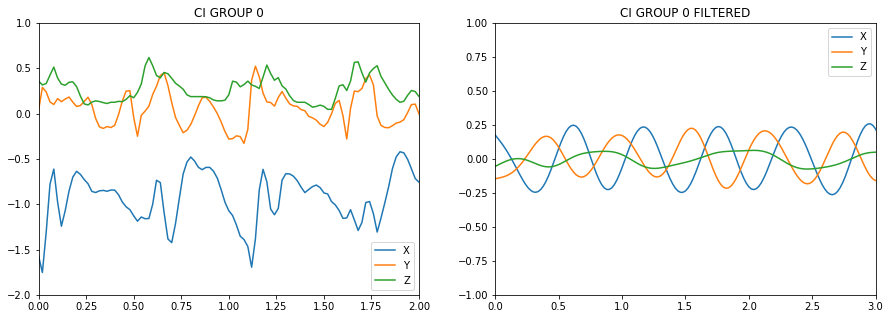

In [7]:
xf_CI = pr.filtering("0","x","CI")[0]
yf_CI = pr.filtering("0","y","CI")[0]
zf_CI = pr.filtering("0","z","CI")[0]

plt.figure(figsize = (15,5))

plt.subplot(121)
plt.plot(x_axis,x_CI, label = "X")
plt.plot(x_axis,y_CI, label = "Y")
plt.plot(x_axis,z_CI, label = "Z")
plt.legend()
plt.xlim(0,2)
plt.ylim(-2,1)
plt.title("CI GROUP 0")

plt.subplot(122)
plt.plot(x_axis,xf_CI, label = "X")
plt.plot(x_axis,yf_CI, label = "Y")
plt.plot(x_axis,zf_CI, label = "Z")
plt.legend()
plt.xlim(0,3)
plt.ylim(-1,1)
plt.title("CI GROUP 0 FILTERED")

### 1.2. Reduction of dimensionality.
The management of high dimensional data is another important challenge in this procedure. In our case, for each subject we have a total of 6 signals: 3 corresponding to the right foot (x, y and z axis) and other 3 signals from the left hip. Taking into account that we have three groups, each with 20 patients, we have a total of **360 signals**. 

In order to simplify the analysis and processing of the signals we have decide to reduce the number of signals we are going to work with so that for each patient we have 2 signals, one from right foot and other from the hip. Having a total of **120 signals**.    

The goal is to find a structure-preserving mapping to a lowdimensional  space. For that we have followed two approaches: 
* Compute the module of the 3 axis (x, y ,z) of the accelerometers
* Principal Component Analysis (PCA) for dimensionlity reduction

#### 1.2.2 Module

Modules are trained to maintain the inner product structure within the original space. It is calculated as the square root of the sum of the squared x-coordinate, the squared y-coordinate and the squared z-coordinate. However, in this case we are not going to use the z-axis to simply things while we do not loose much relevant information.

#### 1.2.3. Principal Analysis Components (PCA)
Overall, principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such way that the new variables (i.e. principal components) are not correlated and most of the information within the initial variables is squeezed or compressed into the first components.  

The **explained variance** tell us how much information (variance) can be attributed to each of the principal components. In order to PCA be a good method to perform, the variance of the first component must represent **at least 80%** of the variance recovered from the three axis x,y,z.  

At first without any type of smoothing, PCA components were very noisy, leading us to low variance of the first component. After applying a band pass filter [0.3-5], since we reduce the complexity of the signal, we have obtained greater variances in the first component.  

Normally, the first components were around 0.80 in most of the cases, but in some groups, some patients did not fulfilled this. Here is a comparison between the media of the explained variance ratio of three groups, however the arguments  of the function can be modified in order to get the variance for each subject instead of getting the mean. Furthermore, this function we have created, returns  list with the first component for further feature extraction.

In [8]:
PCA_g0_PD =pr.pca_method('0','PD',20, plot= False ,explained_variance_ratio_all= False, show_all = False,mean_var_g =True )
PCA_g0_CI= pr.pca_method('0','CI',20, plot= False ,explained_variance_ratio_all= False, show_all = False, mean_var_g =True)

mean value of the components for PD from group 0 [7.65821598e-01 2.34178402e-01 3.02355286e-32]
mean value of the components for CI from group 0 [8.18350109e-01 1.81649891e-01 1.44032722e-32]


In [9]:
PCA_g1_PD= pr.pca_method('1','PD',20, plot= False ,explained_variance_ratio_all= False, show_all = False, mean_var_g =True)
PCA_g1_CI =pr.pca_method('1','CI',20, plot= False ,explained_variance_ratio_all= False, show_all = False, mean_var_g =True)

mean value of the components for PD from group 1 [7.95862237e-01 2.04137763e-01 2.55715173e-32]
mean value of the components for CI from group 1 [7.72357081e-01 2.27642919e-01 1.75535213e-32]


In [10]:
PCA_g2_PD= pr.pca_method('2','PD',20, plot= False ,explained_variance_ratio_all= False, show_all = False,mean_var_g =True )
PCA_g2_CI= pr.pca_method('2','CI',20, plot= False ,explained_variance_ratio_all= False, show_all = False, mean_var_g =True) #### SOFI !! HELP MIRA EL ERROR PORFI 

mean value of the components for PD from group 2 [8.22527794e-01 1.77472206e-01 2.80098143e-32]
mean value of the components for CI from group 2 [8.46423967e-01 1.53576033e-01 2.20583455e-32]


Here, there is an example of the visualizations of the three principal components of a signal. If we take a look at the explained variance ratio, the first component represent the 0.92 of the variance recovered from the three axis.

patient 10 explained variance ratio: [9.27034681e-01 7.29653189e-02 1.11062573e-32]


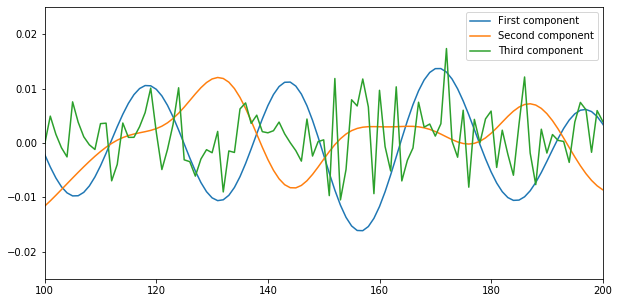

In [11]:
s10_PD= pr.pca_method('0','CI',10, plot= True ,explained_variance_ratio_all= True, show_all = False)

### 1.3. Stationarity.

On the other hand, we are going to study the **stationarity** of the signals in order to define if **their frequency do not change along the time**.

It is a very important property due to the fact that the signal analysis techniques we are going to study will assume the signals are stationary. 

Thence, we are going to visualize **the spectograms** of several signals which will representate the **spectrum of frequencies as the signals varies with time**. So we can decide if we work with the whole signal or just with intervals where they are stationary.

As we cannot plot the whole set of signals to study the stationarity one by one, we are going to plot some example with different combination of origins (different techniques of reduction of dimentionality, group, part of the body) assuming they are defining the stationarity of all of them.

In [12]:
fs = 50

#nperseg=512 because with 1024 the spectogram had too low time resolution and with 256 too low frequency resolution
f0,tt0,Sxx_eeg0 = signal.spectrogram(pr.module("0","PD")[0], fs=fs , nperseg=512)
f1,tt1,Sxx_eeg1 = signal.spectrogram(pr.module("1","CI")[0], fs=fs , nperseg=512)
f2,tt2,Sxx_eeg2 = signal.spectrogram(pr.pca_method("2","PD")[0], fs=fs , nperseg=512)
f3,tt3,Sxx_eeg3 = signal.spectrogram(pr.pca_method("2","CI")[0], fs=fs , nperseg=512)

Text(0.5, 1.0, 'Spectrogram - Group 2 - CI')

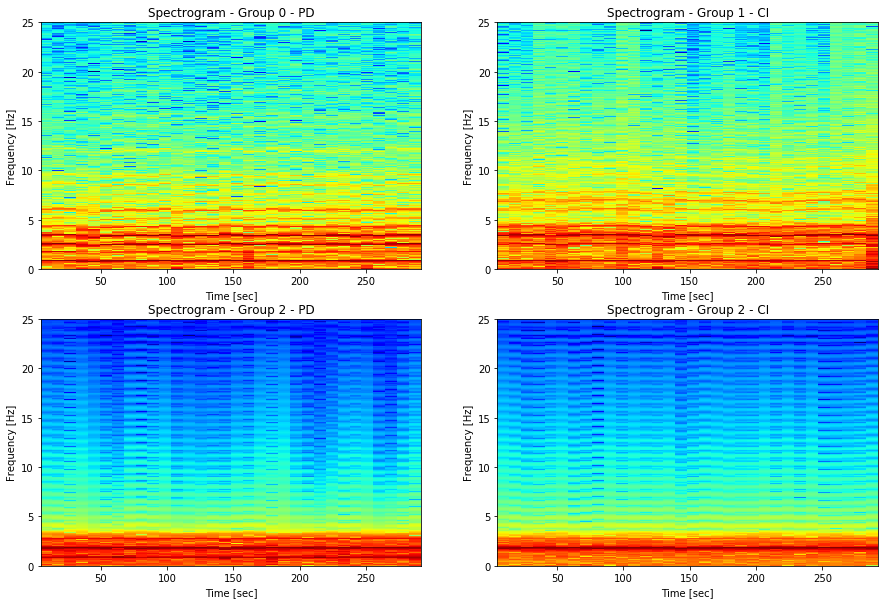

In [13]:
# Plot of the spectrogram
plt.figure(figsize = (15,10))

plt.subplot(221)
plt.pcolormesh(tt0,f0,10*np.log(Sxx_eeg0),cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Group 0 - PD')

plt.subplot(222)
plt.pcolormesh(tt1,f1,10*np.log(Sxx_eeg1),cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Group 1 - CI')

plt.subplot(223)
plt.pcolormesh(tt2,f2,10*np.log(Sxx_eeg2),cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Group 2 - PD')

plt.subplot(224)
plt.pcolormesh(tt3,f3,10*np.log(Sxx_eeg3),cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram - Group 2 - CI')

We cannot appreciate big changes of frequencies along the time so **we will assume the whole set is constituted by signals that are completely stationary**. Thence, we can work with the complete signals.  

## 2. Power Spectral Analysis.

The **power spectral density (PSD)** is a good tool for stationary signal processing and suitable for narrowband signals. It shows us how the signal power is distributed over the frequencies.  

For computing the PSD of the signals we have used the **Welch Method** since as we have previously studied it reduce the variance of the periodogram method by averaging and the leakage by windowing.

Moreover, we have evaluated and study the mean periodograms for each group in order to derive conclusions for the feature extraction. 

In [14]:
## We have created this script with the functions regarding power spectral anlysis
import power_spectral_density as psd

Text(0, 0.5, 'Magnitude (dB)')

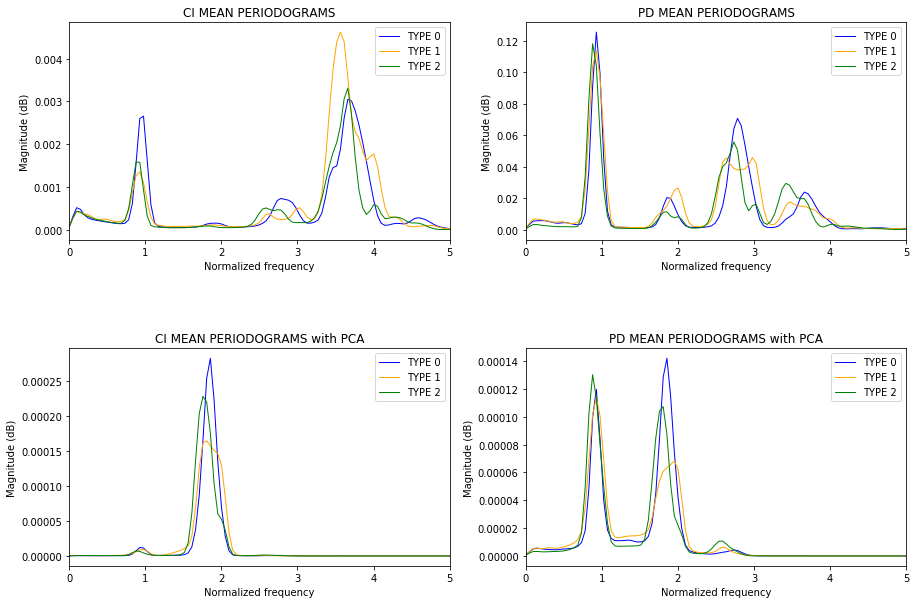

In [15]:
plt.figure(figsize=[15,10])

plt.subplot(221)
plt.subplots_adjust(hspace = 0.5)
plt.plot(psd.mPSD("0","CI")[0], np.mean(psd.mPSD("0","CI")[1], axis=0),'k',linewidth = 1, color = "blue", label = "TYPE 0")
plt.plot(psd.mPSD("1","CI")[0], np.mean(psd.mPSD("1","CI")[1], axis=0),'k',linewidth = 1, color ="orange", label = "TYPE 1")
plt.plot(psd.mPSD("2","CI")[0], np.mean(psd.mPSD("2","CI")[1], axis=0),'k',linewidth = 1, color = "green", label = "TYPE 2")

plt.xlim(0, 5)
plt.legend(loc="upper right") 
plt.title("CI MEAN PERIODOGRAMS")
plt.xlabel('Normalized frequency')
plt.ylabel('Magnitude (dB)')


plt.subplot(222)
plt.subplots_adjust(hspace = 0.5)
plt.plot(psd.mPSD("0","PD")[0], np.mean(psd.mPSD("0","PD")[1], axis=0),'k',linewidth = 1, color = "blue", label = "TYPE 0")
plt.plot(psd.mPSD("1","PD")[0], np.mean(psd.mPSD("1","PD")[1], axis=0),'k',linewidth = 1, color ="orange", label = "TYPE 1")
plt.plot(psd.mPSD("2","PD")[0], np.mean(psd.mPSD("2","PD")[1], axis=0),'k',linewidth = 1, color = "green", label = "TYPE 2")

plt.xlim(0, 5)
plt.legend(loc="upper right") 
plt.title("PD MEAN PERIODOGRAMS")
plt.xlabel('Normalized frequency')
plt.ylabel('Magnitude (dB)')

plt.subplot(223)
plt.subplots_adjust(hspace = 0.5)
plt.plot(psd.pPSD("0","CI")[0], np.mean(psd.pPSD("0","CI")[1], axis=0),'k',linewidth = 1, color = "blue", label = "TYPE 0")
plt.plot(psd.pPSD("1","CI")[0], np.mean(psd.pPSD("1","CI")[1], axis=0),'k',linewidth = 1, color ="orange", label = "TYPE 1")
plt.plot(psd.pPSD("2","CI")[0], np.mean(psd.pPSD("2","CI")[1], axis=0),'k',linewidth = 1, color = "green", label = "TYPE 2")

plt.xlim(0, 5)
plt.legend(loc="upper right") 
plt.title("CI MEAN PERIODOGRAMS with PCA")
plt.xlabel('Normalized frequency')
plt.ylabel('Magnitude (dB)')


plt.subplot(224)
plt.subplots_adjust(hspace = 0.5)
plt.plot(psd.pPSD("0","PD")[0], np.mean(psd.pPSD("0","PD")[1], axis=0),'k',linewidth = 1, color = "blue", label = "TYPE 0")
plt.plot(psd.pPSD("1","PD")[0], np.mean(psd.pPSD("1","PD")[1], axis=0),'k',linewidth = 1, color ="orange", label = "TYPE 1")
plt.plot(psd.pPSD("2","PD")[0], np.mean(psd.pPSD("2","PD")[1], axis=0),'k',linewidth = 1, color = "green", label = "TYPE 2")

plt.xlim(0, 5)
plt.legend(loc="upper right") 
plt.title("PD MEAN PERIODOGRAMS with PCA")
plt.xlabel('Normalized frequency')
plt.ylabel('Magnitude (dB)')

Here we have differentiated periodograms with the module and PCA techniques in order to see when will be useful to use one technique or the other one. 

If we take a closer look to the **mean periodograms obtained from PCA**, we realize that for both hip and foot fundamental frequencies (first peak) are more or less the same for the three groups. However, dominant frequency (second peak) seems to be more characteristic of each group. The power spectral density is higher for type 0 (free walk) and type 2 (placebo), while it is considerable smaller for type 1 (weight).  

In the **mean periodograms from the module** we can observe something similar, the dominant frequencies are more distinctive than fundamental frequencies for each of the groups. Moreover, even though we are not working with the full locomotory band, the first structure of harmonics can be observed.  


## 3. Features extraction and characterization of the signals

In [16]:
## this script contains the functions used for feature extraction
import features as f

### 3.1. Fundamental frequency (f0).

One of the proposes to characterize the different groups is use the fundamental frequency f0 to **represent the gait period for each of them** [3].

This **fundamental frequency** is defined as the lowest frequency that will appear in the periodograms.

To get this feature in a more precise way we are going to follow the following procedure which is inspired by [this article](https://www.frontiersin.org/articles/10.3389/fphys.2018.01061/full). However, it will be shown how this process is done with only one signal but afterwards it will be applied to all of them in order to get the conclusions from the different groups.

Firstly, we apply a **high pass filter** with a frequency of 20 Hz in order to take only very high frequencies.

(0, 12)

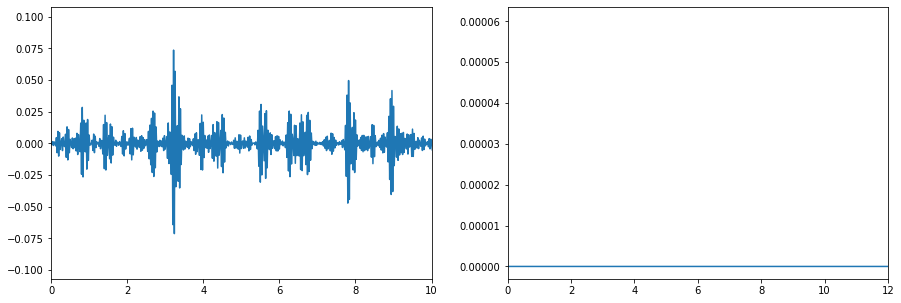

In [17]:
x_2 = np.square(pr.read_data("0","x","CI")[0])
y_2 = np.square(pr.read_data("0","y","CI")[0])
    
example = np.sqrt(x_2 + y_2)
    
b,a = signal.butter(4, Wn = 20,btype = "highpass", fs=fs)
sig_filt1 = signal.filtfilt(b,a, example)
f_welch, Pxx_welch = signal.welch(sig_filt1,fs = fs, window='hamming',nperseg= 512, nfft = 1024)

x_axis = np.arange(0,len(example)/fs,1/fs)

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(x_axis,sig_filt1)
plt.xlim(0,10)
plt.subplot(122)
plt.plot(f_welch,Pxx_welch)
plt.xlim(0,12)

Second step is to **rectify the signal** in order to get only positive values in real time.

(0, 12)

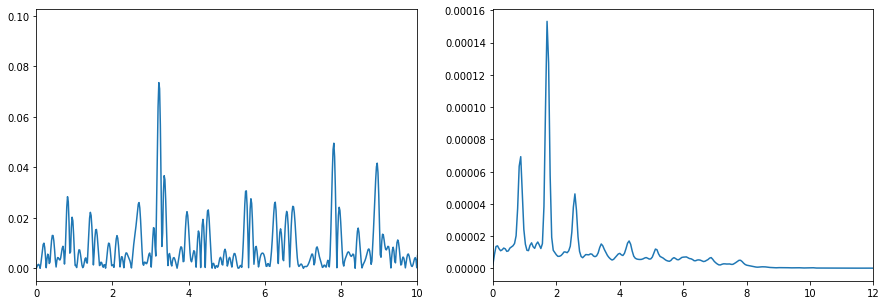

In [18]:
sig_filt1_abs = np.abs(sig_filt1)
f_welch, Pxx_welch = signal.welch(sig_filt1_abs,fs=fs, window='hamming',nperseg= 512, nfft = 1024)

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(x_axis,sig_filt1_abs)
plt.xlim(0,10)
plt.subplot(122)
plt.plot(f_welch,Pxx_welch)
plt.xlim(0,12)

Finally, we apply a **low pass filter** which will allow very low frequencies to pass (lower than 1.5Hz). Thence, we will have a periodogram with a very remarkable peak which will correspond with the f0 of this signal.

(0, 12)

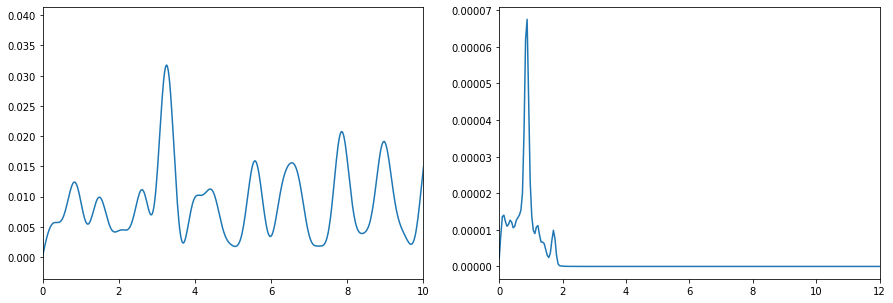

In [19]:
b,a = signal.butter(4, Wn = 1.5 ,btype = "lowpass", fs=fs)
sig_filt2 = signal.filtfilt(b,a, sig_filt1_abs)

f_welch, Pxx_welch = signal.welch(sig_filt2, fs = fs, window='hamming',nperseg = 512, nfft = 1024)

plt.figure(figsize=[15,5])
plt.subplot(121)
plt.plot(x_axis,sig_filt2)
plt.xlim(0, 10)
plt.subplot(122)
plt.plot(f_welch,Pxx_welch)
plt.xlim(0,12)

As we can appreciate, in this case the f0 is placed approximately in 1 Hz.  

Anyhow, as we have mentioned previously we are going to apply this exact procedure to every signal from the different groups to obtain several conclusions regarding their gait period.

In [20]:
f0_g0_PD = f.F0('0','PD')
f0_g1_PD= f.F0('1','PD')
f0_g2_PD= f.F0('2','PD')

f0_g0_CI = f.F0('0','CI')
f0_g1_CI = f.F0('1','CI')
f0_g2_CI = f.F0('2','CI')

Text(0.5, 1.0, 'F0 - CI')

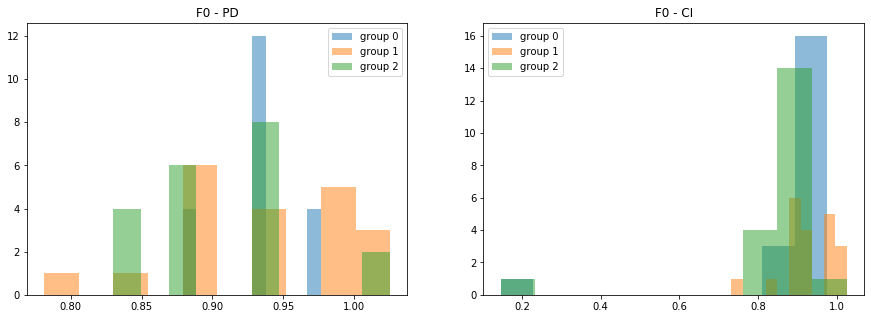

In [21]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist(f0_g0_PD, alpha = 0.5, label = 'group 0')
plt.hist(f0_g1_PD, alpha = 0.5, label = 'group 1')
plt.hist(f0_g2_PD, alpha = 0.5, label = 'group 2')
plt.legend()

plt.title("F0 - PD")

plt.subplot(122)
plt.hist(f0_g0_CI, alpha = 0.5, label = 'group 0')
plt.hist(f0_g1_CI, alpha = 0.5,label = 'group 1')
plt.hist(f0_g2_CI, alpha = 0.5, label = 'group 2')
plt.legend()

plt.title("F0 - CI")

From the one hand, we can appreciate that the **f0 of the lef hip** do not give us important information due to the overlapping of their solutions among groups.

Free walkers does not have any weight or placebo on their limbs which cause to slower the gait, so we were expecting this group to have the highest f0 (lowest period). However, the results are higly affected by the way of walking from volunteers and that is why we don't get exactly what we expected.

Anyway, we will consider the **f0 of the right foot** as an important feature for the further decisor.

### 3.2. Dominant frequency (fd)

This **dominant frequency** can be defined as the one that carries more energy with respect to all the other frequencies in the spectrum.  

Since the PSD from the PCA showed us better distintion between the dominant frequency of the three groups, we have created a function with this technique to compute the periodogram and take the frequency where the highest value of power is found.

In [22]:
pfd_g0_PD = f.pFd('0','PD')
pfd_g1_PD= f.pFd('1','PD')
pfd_g2_PD= f.pFd('2','PD')

pfd_g0_CI = f.pFd('0','CI')
pfd_g1_CI = f.pFd('1','CI')
pfd_g2_CI = f.pFd('2','CI')

Text(0.5, 1.0, 'Fd - CI with PCA')

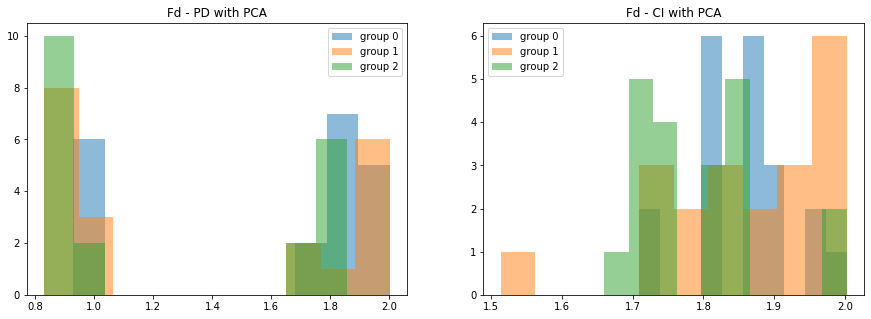

In [23]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.subplots_adjust(hspace = 0.2)
plt.hist(pfd_g0_PD, alpha = 0.5, label = 'group 0')
plt.hist(pfd_g1_PD, alpha = 0.5,label = 'group 1')
plt.hist(pfd_g2_PD, alpha = 0.5,label = 'group 2')
plt.legend()

plt.title("Fd - PD with PCA")

plt.subplot(122)
plt.subplots_adjust(hspace = 0.2)
plt.hist(pfd_g0_CI, alpha = 0.5,label = 'group 0')
plt.hist(pfd_g1_CI, alpha = 0.5,label = 'group 1')
plt.hist(pfd_g2_CI, alpha = 0.5,label = 'group 2')
plt.legend()

plt.title("Fd - CI with PCA")

While there is a high overlapping in the values of the right foot, the **results from the left hip** give us a higher distintion depending the group. This can be useful for our future decisor.

### 3.3. Time intervals between PD and CI.

Walking depends on the repeated performance of a sequence of motions that makes the body advance while maintaining a stable weight-bearing posture. Generally, pathologic conditions alter the mode and efficiency of walking. Through a detailed knowledge of normal function and the types of gait errors that the various pathologic conditions can introduce, doctors are able to diagnose the significant abnormalities.[4] 

This can be perfectly applied to our scenario. Although, our volunteers do not have any pathology (as long as we know and suppose), if something like a weight or a placebo is placed on the limbs, the normal gait cycle of the person will be altered. So time intervals between the peaks of the left hip and the right foot will be also altered.

Thence, we are going to plot some examples from the three different groups in order to see these differences and get some conclusions.

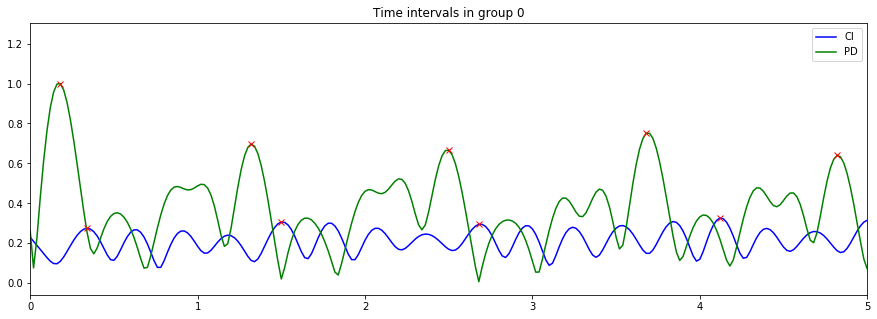

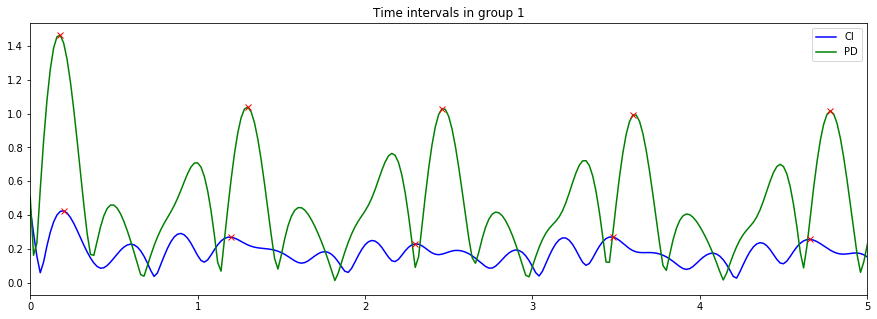

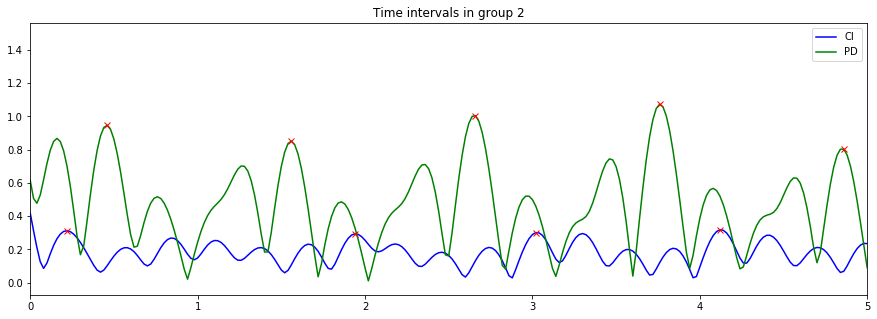

In [24]:
type_patient = ["0","1","2"]

for t in type_patient:

    module_CI = pr.module(t,"CI")[0]
    index_CI, _ = signal.find_peaks(module_CI, distance = fs)

    module_PD = pr.module(t,"PD")[0]
    index_PD, _ = signal.find_peaks(module_PD, distance = fs)

    x_axis = np.arange(0,len(module_CI)/fs,1/fs) 

    plt.figure(figsize=(15,5))
    plt.subplot(111)
    plt.plot(x_axis,module_CI, color = "blue", label = "CI")
    plt.plot(x_axis,module_PD, color = "green", label = "PD")
    plt.plot(x_axis[index_PD],module_PD[index_PD], "x", color = "red")
    plt.plot(x_axis[index_CI],module_CI[index_CI], "x", color = "red")
    plt.xlim(0, 5)
    plt.legend()
    plt.title("Time intervals in group " + t)

Although they are just very singular examples, we can appreciate big difference among them.

When comparing the free walk group with the weight group, we can see clearly in this second type that there is a bigger delay in the appereance of the peak from the hip signal. This make sense as the people with weight has a difficulty to walk so they will take longer to move. In addition, the group with a placebo has a different pattern than the other two.  

Now the goal is to measure this differentation in some way. For so, we are going to calculate the standard deviation of all the time intervals from the different groups to know the existing variation.  

In this case, we obtained better results with the module, so the function we are using works with this method.

In [25]:
mintervals_g0= f.mIntervals("0")
mintervals_g1= f.mIntervals("1")
mintervals_g2= f.mIntervals("2")

Text(0.5, 1.0, 'Time intervals between PD and CI')

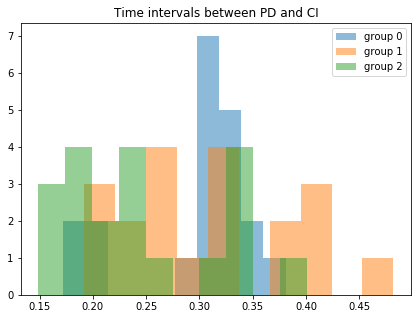

In [26]:
plt.figure(figsize=(7,5))
plt.hist(mintervals_g0, alpha = 0.5, label= 'group 0')
plt.hist(mintervals_g1, alpha = 0.5, label= 'group 1')
plt.hist(mintervals_g2, alpha = 0.5, label= 'group 2')
plt.legend()

plt.title("Time intervals between PD and CI")

Despite of the overlapping, this feature could be useful in order to characterize some subjects from different groups.

### 3.4. Variability Characterization
We are going to analyse how power is distributed among the different spectral peaks. We will take the band [1-3] as the band of interest, where the dominant frequency lies in. We are interested in extract the following parameters:
1. **Total power of the signal **
2. **Average band power**: the contribution of the frequency band of interest to the overall power of the signal
2. **Relative band power**: the power in the frequency band of interest as percentage of the total power of the signal

As we have been doing previously, we will compare both signals from module and PCA in order to study which result seems better.

In [27]:
###PD y CI usando PCA
ri_0P,totalp_0P, bandp_0P= f.power('0', 'PD')
ri_1P,totalp_1P, bandp_1P= f.power('1', 'PD')
ri_2P,totalp_2P, bandp_2P= f.power('2', 'PD')

ri_0C,totalp_0C, bandp_0C= f.power('0', 'CI')
ri_1C,totalp_1C, bandp_1C= f.power('1', 'CI')
ri_2C,totalp_2C, bandp_2C= f.power('2', 'CI')

Text(0.5, 1.0, 'Total power- PCA')

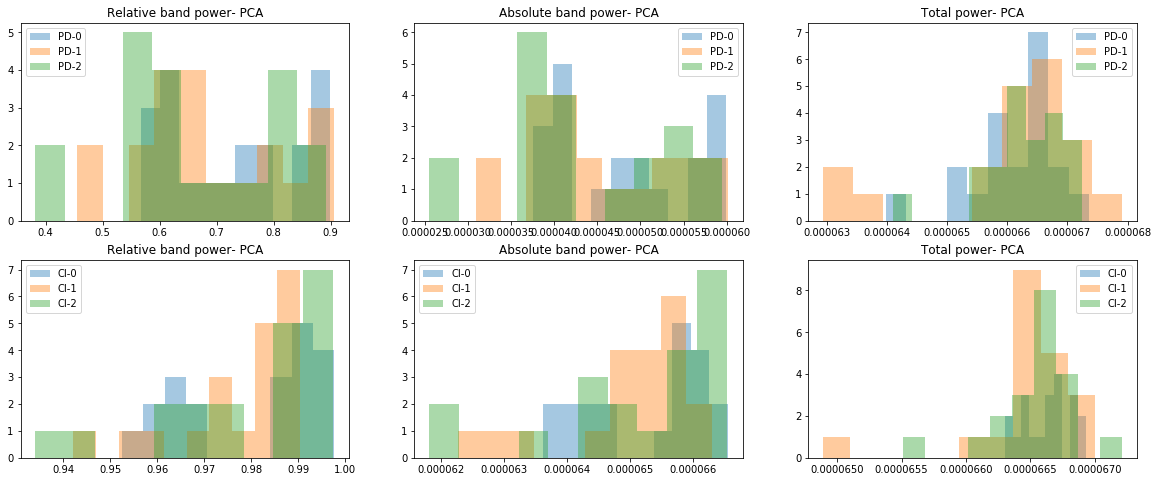

In [28]:
plt.figure(figsize = (20,8))

plt.subplot(231)
plt.hist(ri_0P, alpha=0.4, label = 'PD-0')
plt.hist(ri_1P,alpha=0.4, label= 'PD-1')
plt.hist(ri_2P, alpha=0.4, label = 'PD-2')
plt.legend()
plt.title('Relative band power- PCA')

plt.subplot(232)
plt.hist(bandp_0P, alpha=0.4, label = 'PD-0')
plt.hist(bandp_1P,alpha=0.4, label= 'PD-1')
plt.hist(bandp_2P, alpha=0.4, label = 'PD-2')
plt.legend()
plt.title('Absolute band power- PCA')

plt.subplot(233)
plt.hist(totalp_0P, alpha=0.4, label = 'PD-0')
plt.hist(totalp_1P,alpha=0.4, label= 'PD-1')
plt.hist(totalp_2P, alpha=0.4, label = 'PD-2')
plt.legend()
plt.title('Total power- PCA')
         
         
plt.subplot(234)
plt.hist(ri_0C, alpha=0.4, label = 'CI-0')
plt.hist(ri_1C,alpha=0.4, label= 'CI-1')
plt.hist(ri_2C, alpha=0.4, label = 'CI-2')
plt.legend()
plt.title('Relative band power- PCA')

plt.subplot(235)
plt.hist(bandp_0C, alpha=0.4, label = 'CI-0')
plt.hist(bandp_1C,alpha=0.4, label= 'CI-1')
plt.hist(bandp_2C, alpha=0.4, label = 'CI-2')
plt.legend()
plt.title('Absolute band power- PCA')

plt.subplot(236)
plt.hist(totalp_0C, alpha=0.4, label = 'CI-0')
plt.hist(totalp_1C,alpha=0.4, label= 'CI-1')
plt.hist(totalp_2C, alpha=0.4, label = 'CI-2')
plt.legend()
plt.title('Total power- PCA')

From the histograms, despite of the overlapping we think the **absolute band** and **relative band power from right foot** could be of interest since we could differentiante some signals from group two and one. For the same reason the **total power from left hip** could be interesting. Moreover, we also consider the **absolute band power of hip** since we could characterize some signals from group cero.

For the module signals we are going to carry out a **full spectra analysis** considering the band of interest [1-3] but this time over the whole signal [0-15] which corresponds to the full locomotory spectrum. 

In [29]:
ri_0P_m,totalp_0P_m,bandp_0P_m = f.power_m('0', 'PD')
ri_1P_m, totalp_1P_m,bandp_1P_m = f.power_m('1', 'PD')
ri_2P_m,totalp_2P_m,bandp_2P_m = f.power_m('2', 'PD')

ri_0C_m,totalp_0C_m,bandp_0C_m = f.power_m('0', 'CI')
ri_1C_m, totalp_1C_m,bandp_1C_m =f. power_m('1', 'CI')
ri_2C_m,totalp_2C_m,bandp_2C_m = f.power_m('2', 'CI')

Text(0.5, 1.0, 'Total power- module')

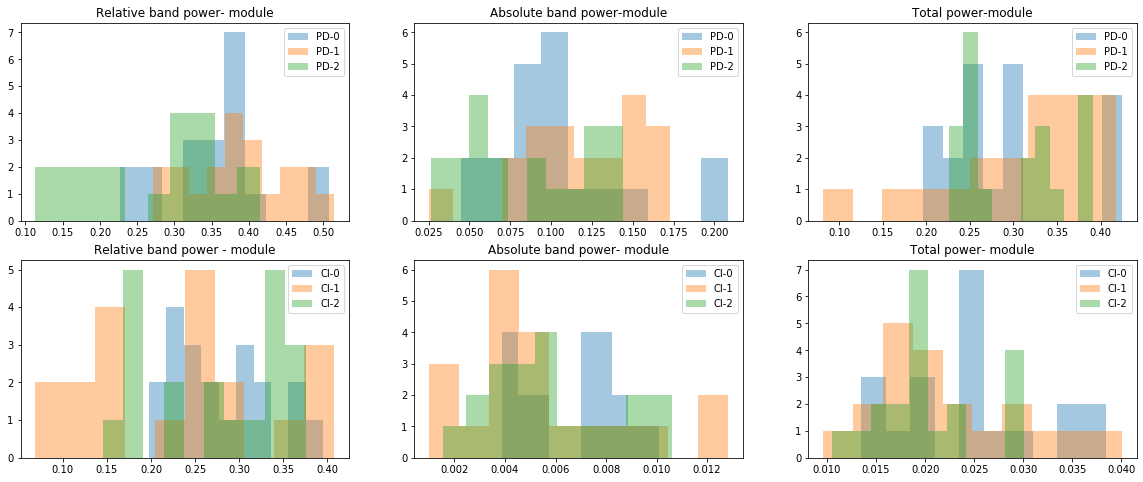

In [30]:
plt.figure(figsize = (20,8))

plt.subplot(231)
plt.hist(ri_0P_m, alpha=0.4, label = 'PD-0')
plt.hist(ri_1P_m,alpha=0.4, label= 'PD-1')
plt.hist(ri_2P_m, alpha=0.4, label = 'PD-2')
plt.legend()
plt.title('Relative band power- module')

plt.subplot(232)
plt.hist(bandp_0P_m, alpha=0.4, label = 'PD-0')
plt.hist(bandp_1P_m,alpha=0.4, label= 'PD-1')
plt.hist(bandp_2P_m, alpha=0.4, label = 'PD-2')
plt.legend()
plt.title('Absolute band power-module')

plt.subplot(233)
plt.hist(totalp_0P_m, alpha=0.4, label = 'PD-0')
plt.hist(totalp_1P_m,alpha=0.4, label= 'PD-1')
plt.hist(totalp_2P_m, alpha=0.4, label = 'PD-2')
plt.legend()
plt.title('Total power-module')
         
         
plt.subplot(234)
plt.hist(ri_0C_m, alpha=0.4, label = 'CI-0')
plt.hist(ri_1C_m,alpha=0.4, label= 'CI-1')
plt.hist(ri_2C_m, alpha=0.4, label = 'CI-2')
plt.legend()
plt.title('Relative band power - module')

plt.subplot(235)
plt.hist(bandp_0C_m, alpha=0.4, label = 'CI-0')
plt.hist(bandp_1C_m,alpha=0.4, label= 'CI-1')
plt.hist(bandp_2C_m , alpha=0.4, label = 'CI-2')
plt.legend()
plt.title('Absolute band power- module')

plt.subplot(236)
plt.hist(totalp_0C_m, alpha=0.4, label = 'CI-0')
plt.hist(totalp_1C_m,alpha=0.4, label= 'CI-1')
plt.hist(totalp_2C_m, alpha=0.4, label = 'CI-2')
plt.legend()
plt.title('Total power- module')

Here again, despite of the overlapping, we consider that **relative band power for right foot** could be of interest since we could distinguish few signals without overlapping for the three groups. With the **absolute band power of foot** we could differentiate some signals from group cero and with the **relative band power for the hip** we could  diferentiate some of group one.

#### Analysis of the results

After studying the previous feautures we have obtained several conclusions which have been explained during the procedure:  

* **Group 0**: higher fundamental frecuency due to the smallest period and shorter time intervals between right foot and left hip  
* **Group 1**: longer time interval between right foot and left hip and lowest fundamental frequency  
* **Group 2**: values obtained from power are similar but slightly different from group 0.


## 4. Implementation of Naïve Bayes Decisor
We procced to implement the Naïve Bayes Detector. **Naive Bayes methods** are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional **independence between every pair of features** given the value of the class variable.  

There are different types of Naïve Bayes Clasifiers,we will use **GaussianNB** that implements the Gaussian Naive Bayes algorithm for classification where the **likelihood of the features is assumed to be Gaussian**.  

Another assupmtion made is that all predictors have an equal effect on the outcome, that is to say that that the group prior probability will be the same for group 0 (free walk), group 1(weight) and group 2 (placebo) being 1/3 . 



In [31]:
from sklearn.naive_bayes import GaussianNB
Prior_0 = 1/3
Prior_1 = 1/3
Prior_2 = 1/3

Based on the analysis of the histograms we proceed to to the **feature selection**. Manually, we have selected the features that could characterized the three groups better and could contribute the most in the prediction. Moreover, we are aware that having **irrelevant features could decrease the accuracy of our model**.

In [32]:
#1-f0:pd
f0_PD= np.concatenate((f0_g0_PD, f0_g1_PD,f0_g2_PD))

#2-fd:ci
fd_CI= np.concatenate((pfd_g0_CI, pfd_g1_CI,pfd_g2_CI))

#3-intervals pd-ci module
intervals= np.concatenate((mintervals_g0, mintervals_g1,mintervals_g2))

#4-relative band power:pd-PCA
rbp_PD =  np.concatenate((ri_0P, ri_1P,ri_2P))

rbp_CI = np.concatenate((ri_0C, ri_1C,ri_2C))

#5-absolute band power: pd-PCA
abp_PD =  np.concatenate((bandp_0P, bandp_1P,bandp_2P))

#6-absolute band power: ci-PCA
abp_CI = np.concatenate((bandp_0C, bandp_1C, bandp_2C))
 
#7-TOTAL power: ci-pca
totalp_CI =  np.concatenate((totalp_0C, totalp_1C,totalp_2C))

#8-relative band power: pd-Module
rbp_PD_m= np.concatenate((ri_0P_m, ri_1P_m,ri_2P_m))

#9-relative band powe: ci- module
rbp_CI_m = np.concatenate((ri_0C_m, ri_1C_m,ri_2C_m))

##10- absolute pand power: pd module
abp_PD_m = np.concatenate((bandp_0P_m, bandp_1P_m,bandp_2P_m))

We implement the **Matrix of Characteristics** in which we have 60 rows corresponding to the number of subjects and M columns corresponding to the number of selected features. The first 20 rows correspond to subjects from group 0, the following 20 to group 1, and the last 20 to group 2. Moreover we create the **label matrix** which includes the labels for each gruop, being 0,1 or 2 in the same order as before. 

In [33]:
X_s= np.zeros((60,6))
X_s[:,0]= f0_PD
X_s[:,1]= fd_CI
X_s[:,2]= intervals
#X_s[:,3]= rbp_CI
#X_s[:,4]= abp_PD
#X_s[:,5]= abp_CI
#X_s[:,6]= rbp_CI
X_s[:,3]= rbp_PD_m
X_s[:,4]= rbp_CI_m
X_s[:,5]= abp_PD_m

labels= np.zeros(60)
labels[20:40]= 1
labels[40:60]= 2

In [34]:
nb_detector = GaussianNB(priors = [Prior_0,Prior_1,Prior_2])
nb_detector.fit(X_s,labels)
D = nb_detector.predict(X_s)
print('ACC = %.2f'%np.mean(D == labels))
print(D)

ACC = 0.65
[2. 0. 2. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 1. 1. 1.
 1. 0. 1. 2. 0. 1. 2. 1. 2. 1. 1. 0. 1. 2. 1. 1. 2. 2. 2. 0. 2. 2. 1. 2.
 0. 2. 2. 0. 2. 2. 2. 0. 0. 1. 2. 2.]


#### Analysis of the results

We are aware that having an **accuracy of 0.65** is not pretty good for a predictive model. We also known that features selection is one of the most important steps in designing our model.  

We really thought that feautures extracted (fundamental and dominant frequencies, intervals between peaks, power in different frequencies band) were good in order to characterize each of the groups. But the obtained results are worse than we expected.

It may be due to preprocessing issues, or the procedures to extract those features. Or maybe, the selection of the relevant features. Moreover, we could have use fewer data points in order to reduce the algorithm comlexity. Having less redundat data could have reduced the decisions based on noise.

## 5. Prediction for Test Subjects uploaded to Kaggle 
The Test Set is composed by 30 subjects. For each subject we have 6 signals. Three from the right foot (x,y,z) and other three for left hip. Which makes a total of 180 signals. We have apply the same procedures, methods and feature extration for the signals of the test set. All this functions have been put togheter in the a utility script for simplicity. 


In [35]:
import functions_for_test_set as t

In [36]:
f0_test_CI = t.F0_test("CI")
f0_test_PD = t.F0_test("PD") 
fd_test_CI = t.Fd_test("CI") 
fd_test_PD = t.Fd_test("PD")
mIntervals_test = t.test_intervals()

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'C:/psp-urjc-challenge-1920/Data/Test'

In [ ]:
ri_PD_m_test, totalp_PD_m_test, bandp_PD_m_test = t.power_m_test('PD')
ri_CI_m_test, totalp_CI_m_test, bandp_CI_m_test = t.power_m_test('CI')

ri_PD_test, totalp_PD_test, bandp_PD_test = t.power_test('PD')
ri_CI_test, totalp_CI_test, bandp_CI_test = t.power_test('CI')

In [ ]:
X_sp= np.zeros((30,6))
X_sp[:,0]= f0_test_PD 
X_sp[:,1]= fd_test_CI
X_sp[:,2]= mIntervals_test
X_sp[:,3]= ri_PD_m_test
X_sp[:,4]= ri_CI_m_test
X_sp[:,5]= bandp_PD_m_test

Finally, this is the prediction we have uploaded to kaggle in our final submission:

In [ ]:
D = nb_detector.predict(X_sp)
print(D)

Although with previuos submission on Kaggle we achieved higher scores we finally decided to submit this prediction since we get a higher accuracy in the decisor and more reasonable results. 

### References 
[1] https://link.springer.com/article/10.1007/s13721-012-0020-8  

[2] https://link.springer.com/referenceworkentry/10.1007%2F978-3-319-30808-1_178-1  

[3] https://www.frontiersin.org/articles/10.3389/fphys.2018.01061/full  

[4] http://www.oandplibrary.org/alp/chap13-01.asp
